# 07 – Cross-Validation (Baseline Model)

Ziel: Robuste Evaluation der klassischen Baseline mittels k-fold Cross-Validation.
Die Ergebnisse werden als Mittelwert und Standardabweichung berichtet.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

PROJECT_ROOT = Path.cwd().parent
DATA_CSV = PROJECT_ROOT / "data" / "processed" / "bbc_news.csv"

results_dir = PROJECT_ROOT / "results" / "cross_validation"
results_dir.mkdir(parents=True, exist_ok=True)

df = pd.read_csv(DATA_CSV)
X = df["text"].astype(str).values
y = df["label"].values
labels_sorted = sorted(df["label"].unique())

print(f"Samples: {len(X)}")
print(f"Classes: {labels_sorted}")

Samples: 2225
Classes: ['business', 'entertainment', 'politics', 'sport', 'tech']


In [2]:
def make_baseline_model():
    return Pipeline([
        ("tfidf", TfidfVectorizer(
            max_features=50000,
            ngram_range=(1,2),
            stop_words="english"
        )),
        ("clf", LogisticRegression(
            max_iter=2000,
            n_jobs=-1
        ))
    ])


In [3]:
import time

N_SPLITS = 5
SEED = 42

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

fold_rows = []        # Einzelne Fold-Ergebnisse
y_true_all = []       # Für Confusion Matrix
y_pred_all = []       # Für Confusion Matrix

start_total = time.time()

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    fold_start = time.time()
    
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = make_baseline_model()
    model.fit(X_train, y_train)

    preds = model.predict(X_test)

    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average="macro")
    fold_time = time.time() - fold_start

    # Für Confusion Matrix sammeln
    y_true_all.extend(y_test.tolist())
    y_pred_all.extend(preds.tolist())
    
    # Fold-Ergebnisse speichern
    fold_rows.append({
        "model": "TF-IDF + LogReg",
        "fold": fold,
        "n_splits": N_SPLITS,
        "eval_accuracy": acc,
        "eval_macro_f1": f1,
        "time_sec": round(fold_time, 2)
    })

    print(f"Fold {fold}: accuracy={acc:.4f}, macro-F1={f1:.4f}, time={fold_time:.2f}s")

total_time = time.time() - start_total
print(f"\n⏱️ Total training time: {total_time:.2f}s")

# DataFrame mit allen Fold-Ergebnissen
df_folds = pd.DataFrame(fold_rows)
df_folds

Fold 1: accuracy=0.9708, macro-F1=0.9699, time=2.44s
Fold 2: accuracy=0.9888, macro-F1=0.9889, time=1.92s
Fold 3: accuracy=0.9730, macro-F1=0.9731, time=1.97s
Fold 4: accuracy=0.9865, macro-F1=0.9859, time=1.83s
Fold 5: accuracy=0.9775, macro-F1=0.9773, time=2.06s

⏱️ Total training time: 10.22s


,model,fold,n_splits,eval_accuracy,eval_macro_f1,time_sec
0,TF-IDF + LogReg,1,5,0.970787,0.969882,2.44
1,TF-IDF + LogReg,2,5,0.988764,0.988940,1.92
2,TF-IDF + LogReg,3,5,0.973034,0.973055,1.97
3,TF-IDF + LogReg,4,5,0.986517,0.985874,1.83
4,TF-IDF + LogReg,5,5,0.977528,0.977321,2.06


In [4]:
print("=" * 50)
print("BASELINE 5-FOLD CROSS-VALIDATION RESULTS")
print("=" * 50)

acc_mean = df_folds["eval_accuracy"].mean()
acc_std = df_folds["eval_accuracy"].std()
f1_mean = df_folds["eval_macro_f1"].mean()
f1_std = df_folds["eval_macro_f1"].std()

print(f"\nAccuracy:  {acc_mean:.4f} ± {acc_std:.4f}")
print(f"Macro-F1:  {f1_mean:.4f} ± {f1_std:.4f}")
print(f"Total Time: {total_time:.2f}s")

# 1. Fold-Ergebnisse speichern (für Vergleich mit Transformer)
folds_path = results_dir / "cv_baseline_5fold_folds.csv"
df_folds.to_csv(folds_path, index=False)
print(f"\n✅ Fold-Ergebnisse: {folds_path}")

# 2. Summary speichern (wie bisher)
summary = {
    "model": "TF-IDF + LogReg",
    "n_splits": N_SPLITS,
    "acc_mean": acc_mean,
    "acc_std": acc_std,
    "mf1_mean": f1_mean,
    "mf1_std": f1_std,
    "total_time_sec": total_time,
    "time_per_fold_sec": df_folds["time_sec"].mean()
}

summary_df = pd.DataFrame([summary])
summary_path = results_dir / "cv_baseline_5fold_summary.csv"
summary_df.to_csv(summary_path, index=False)
print(f"✅ Summary: {summary_path}")

BASELINE 5-FOLD CROSS-VALIDATION RESULTS

Accuracy:  0.9793 ± 0.0080
Macro-F1:  0.9790 ± 0.0082
Total Time: 10.22s

✅ Fold-Ergebnisse: c:\CAS\cas-ml-document-classification\results\cross_validation\cv_baseline_5fold_folds.csv
✅ Summary: c:\CAS\cas-ml-document-classification\results\cross_validation\cv_baseline_5fold_summary.csv


## Normalized Confusion Matrix (aggregiert über alle Folds)

## Accuracy pro Fold (Baseline)

✅ Fold-Plot: c:\CAS\cas-ml-document-classification\results\cross_validation\cv_baseline_5fold_accuracy.png


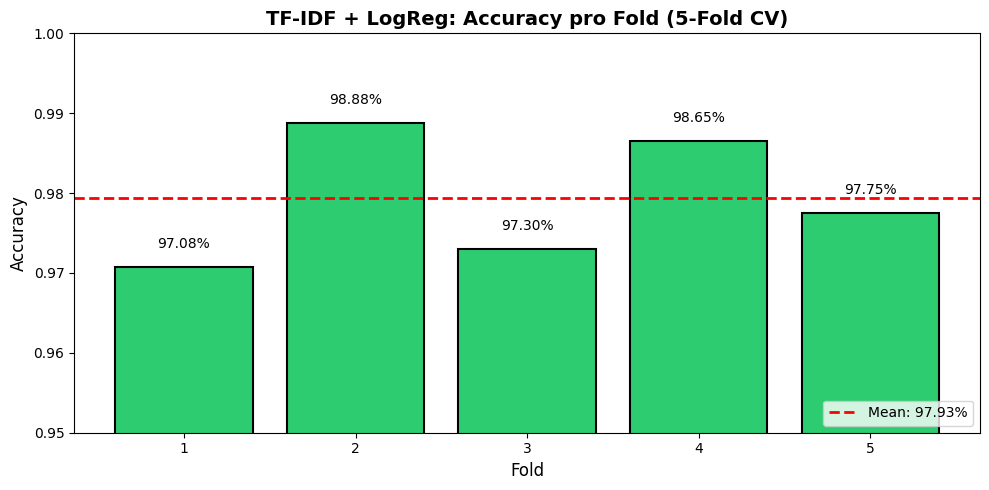

In [5]:
# Plot: Accuracy pro Fold für Baseline
fig, ax = plt.subplots(figsize=(10, 5))

folds = df_folds['fold'].values
accuracies = df_folds['eval_accuracy'].values

bars = ax.bar(folds, accuracies, color='#2ecc71', edgecolor='black', linewidth=1.5)

# Mittelwert-Linie
ax.axhline(y=acc_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {acc_mean:.2%}')

# Werte auf Balken
for bar, acc in zip(bars, accuracies):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
            f'{acc:.2%}', ha='center', va='bottom', fontsize=10)

ax.set_xlabel('Fold', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('TF-IDF + LogReg: Accuracy pro Fold (5-Fold CV)', fontsize=14, fontweight='bold')
ax.set_ylim(0.95, 1.0)
ax.set_xticks(folds)
ax.legend(loc='lower right')

plt.tight_layout()

fold_plot_path = results_dir / "cv_baseline_5fold_accuracy.png"
plt.savefig(fold_plot_path, dpi=300, bbox_inches='tight')
print(f"✅ Fold-Plot: {fold_plot_path}")
plt.show()

✅ Confusion Matrix: c:\CAS\cas-ml-document-classification\results\cross_validation\cv_baseline_confusion_matrix.png


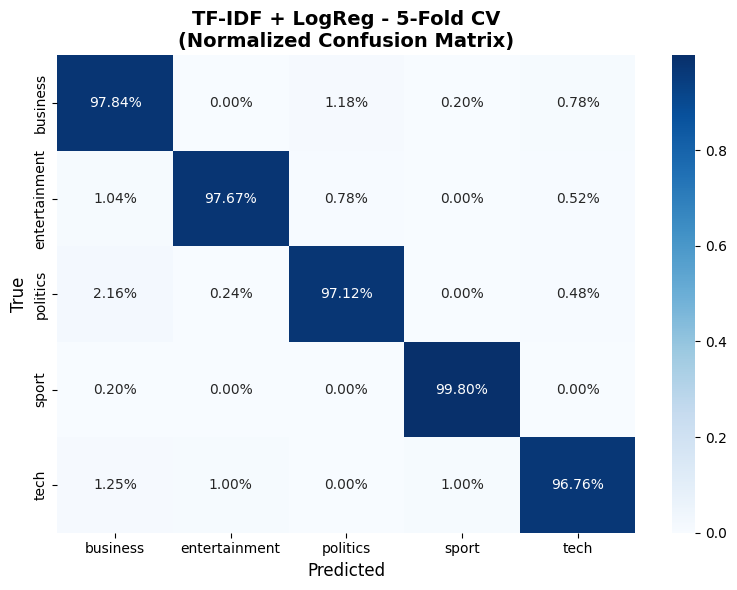

In [ ]:
# Confusion Matrix berechnen (aggregiert über alle Folds)
cm = confusion_matrix(y_true_all, y_pred_all, labels=labels_sorted)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=labels_sorted, yticklabels=labels_sorted, ax=ax)
ax.set_xlabel('Vorhergesagt', fontsize=12, fontweight='bold')
ax.set_ylabel('Tatsächlich', fontsize=12, fontweight='bold')
ax.set_title('TF-IDF + LogReg - 5-Fold CV\n(Normalisierte Confusion Matrix)', fontsize=14, fontweight='bold')

plt.tight_layout()

cm_path = results_dir / "cv_baseline_confusion_matrix.png"
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
print(f"✅ Confusion Matrix: {cm_path}")
plt.show()

## CV-Vergleich: Baseline vs. DistilBERT

Erstellt einen Vergleichsplot der Cross-Validation Ergebnisse für die Transferarbeit.

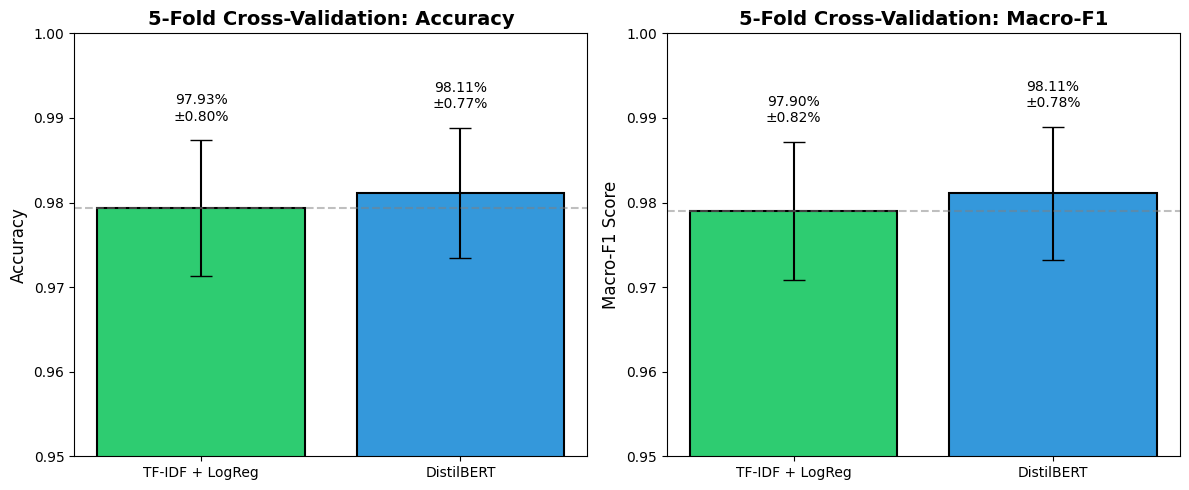


✅ Plot gespeichert: c:\CAS\cas-ml-document-classification\results\cross_validation\cv_comparison.png


In [7]:
# CV-Ergebnisse laden (DistilBERT hat Fold-Daten, nicht Summary)
cv_distilbert_path = results_dir / "cv_distilbert-base-uncased_5fold_summary.csv"
cv_distilbert_folds = pd.read_csv(cv_distilbert_path)

# Mean/Std für DistilBERT berechnen
distilbert_acc_mean = cv_distilbert_folds['eval_accuracy'].mean()
distilbert_acc_std = cv_distilbert_folds['eval_accuracy'].std()
distilbert_f1_mean = cv_distilbert_folds['eval_macro_f1'].mean()
distilbert_f1_std = cv_distilbert_folds['eval_macro_f1'].std()

# Daten für Plot (Baseline aus df_folds, DistilBERT aus CSV)
models = ['TF-IDF + LogReg', 'DistilBERT']
acc_means = [acc_mean, distilbert_acc_mean]
acc_stds = [acc_std, distilbert_acc_std]
f1_means = [f1_mean, distilbert_f1_mean]
f1_stds = [f1_std, distilbert_f1_std]

# Plot erstellen
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

colors = ['#2ecc71', '#3498db']  # Grün für Baseline, Blau für DistilBERT

# Accuracy Plot
ax1 = axes[0]
bars1 = ax1.bar(models, acc_means, yerr=acc_stds, capsize=8, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('5-Fold Cross-Validation: Accuracy', fontsize=14, fontweight='bold')
ax1.set_ylim(0.95, 1.0)
ax1.axhline(y=acc_means[0], color='gray', linestyle='--', alpha=0.5)

# Werte auf Balken
for bar, mean, std in zip(bars1, acc_means, acc_stds):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.002, 
             f'{mean:.2%}\n±{std:.2%}', ha='center', va='bottom', fontsize=10)

# Macro-F1 Plot
ax2 = axes[1]
bars2 = ax2.bar(models, f1_means, yerr=f1_stds, capsize=8, color=colors, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Macro-F1 Score', fontsize=12)
ax2.set_title('5-Fold Cross-Validation: Macro-F1', fontsize=14, fontweight='bold')
ax2.set_ylim(0.95, 1.0)
ax2.axhline(y=f1_means[0], color='gray', linestyle='--', alpha=0.5)

# Werte auf Balken
for bar, mean, std in zip(bars2, f1_means, f1_stds):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.002, 
             f'{mean:.2%}\n±{std:.2%}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()

# Speichern
plot_path = results_dir / "cv_comparison.png"
plt.savefig(plot_path, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n✅ Plot gespeichert: {plot_path}")

## Accuracy pro Fold: Alle 3 Modelle im Vergleich

✅ Fold-Vergleich: c:\CAS\cas-ml-document-classification\results\cross_validation\cv_all_models_folds_accuracy.png


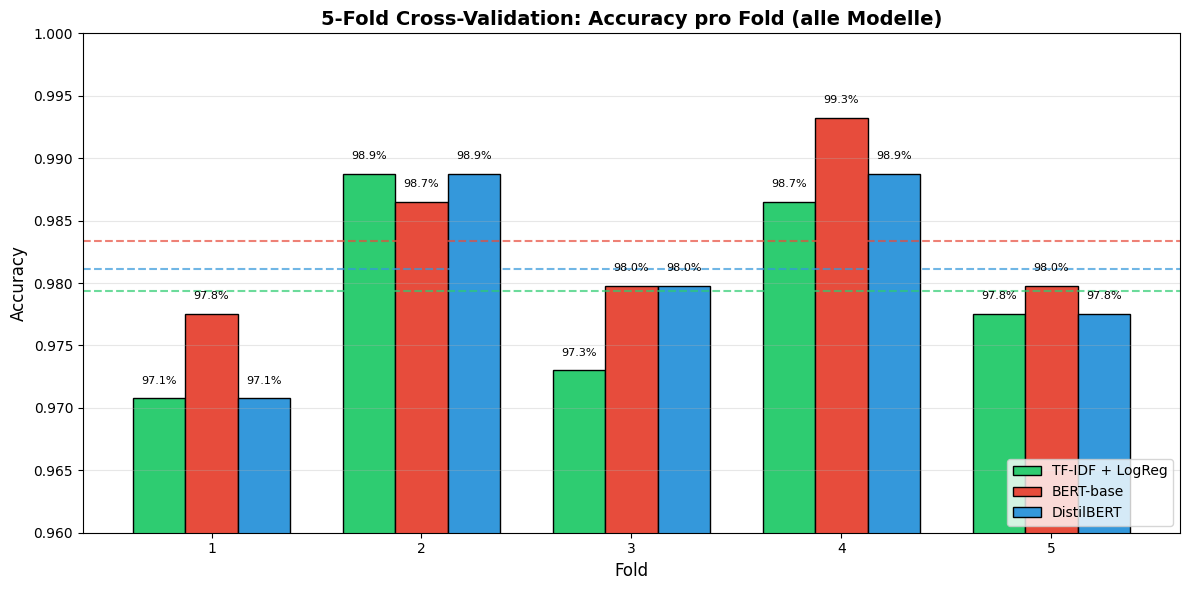

In [8]:
# Fold-Daten für alle 3 Modelle laden
cv_bert_path = results_dir / "cv_bert-base-uncased_5fold_summary.csv"
cv_bert_folds = pd.read_csv(cv_bert_path)

# Daten zusammenstellen
folds = [1, 2, 3, 4, 5]

baseline_acc = df_folds['eval_accuracy'].values
distilbert_acc = cv_distilbert_folds['eval_accuracy'].values
bert_acc = cv_bert_folds['eval_accuracy'].values

# Plot erstellen
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(folds))
width = 0.25

# Grouped Bar Chart
bars1 = ax.bar(x - width, baseline_acc, width, label='TF-IDF + LogReg', color='#2ecc71', edgecolor='black')
bars2 = ax.bar(x, bert_acc, width, label='BERT-base', color='#e74c3c', edgecolor='black')
bars3 = ax.bar(x + width, distilbert_acc, width, label='DistilBERT', color='#3498db', edgecolor='black')

# Mittelwert-Linien
ax.axhline(y=baseline_acc.mean(), color='#2ecc71', linestyle='--', alpha=0.7, linewidth=1.5)
ax.axhline(y=bert_acc.mean(), color='#e74c3c', linestyle='--', alpha=0.7, linewidth=1.5)
ax.axhline(y=distilbert_acc.mean(), color='#3498db', linestyle='--', alpha=0.7, linewidth=1.5)

# Werte auf Balken
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.001, 
                f'{height:.1%}', ha='center', va='bottom', fontsize=8, rotation=0)

ax.set_xlabel('Fold', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('5-Fold Cross-Validation: Accuracy pro Fold (alle Modelle)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(folds)
ax.set_ylim(0.96, 1.0)
ax.legend(loc='lower right', fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()

# Speichern
fold_comparison_path = results_dir / "cv_all_models_folds_accuracy.png"
plt.savefig(fold_comparison_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✅ Fold-Vergleich: {fold_comparison_path}")
plt.show()